In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [4]:
csv1 = "movie_data/movies.csv"
csv2 = "movie_data/ratings.csv"
csv3 = "movie_data/genome-scores.csv"
csv4 = "movie_data/genome-tags.csv"
csv5 = "movie_data/links.csv"
csv6 = "movie_data/tags.csv"

In [5]:
movies_df = pd.read_csv(csv1)
ratings_df = pd.read_csv(csv2)
genome_scores_df = pd.read_csv(csv3)
genome_tags_df = pd.read_csv(csv4)
links_df = pd.read_csv(csv5)
tags_df = pd.read_csv(csv6)

In [6]:
print(f'{len(movies_df)} movies')
print(f'{len(ratings_df)} ratings')

62423 movies
25000095 ratings


In [7]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [8]:
# # Number of ratings for each userId
# ratings_df.groupby(ratings_df['userId'])['rating'].count()

In [9]:
genome_scores_df.head()

,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


In [10]:
relevant_genome_scores_df = genome_scores_df.loc[genome_scores_df['relevance'] > .85]

In [11]:
genome_tags_df.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [12]:
links_df.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [13]:
tags_df.head()

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


In [14]:
new_df = ratings_df.merge(movies_df, how="inner")
new_df = new_df.drop(columns=['title', 'genres', 'timestamp'])
new_df.head()

,userId,movieId,rating
0,1,296,5.0
1,3,296,5.0
2,4,296,4.0
3,5,296,4.0
4,7,296,4.0


In [15]:
new_df["rating"] = np.where(new_df["rating"] >= 3.5, 1, 0)

In [16]:
new_df

,userId,movieId,rating
0,1,296,1
1,3,296,1
2,4,296,1
3,5,296,1
4,7,296,1
...,...,...,...
25000090,162358,200192,0
25000091,162358,200194,0
25000092,162386,139970,1
25000093,162386,200726,1


In [17]:
X = new_df.drop('rating', axis=1)
y = new_df['rating']

In [18]:
from sklearn import preprocessing
from sklearn import utils

#convert y values to categorical values
lab = preprocessing.LabelEncoder()
y_transformed = lab.fit_transform(y)

#view transformed values
print(y_transformed)
X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, random_state=1)

[1 1 1 ... 1 1 1]


In [19]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
print(f"Training Data Score: {classifier.score(X_train, y_train)}")
print(f"Testing Data Score: {classifier.score(X_test, y_test)}")

Training Data Score: 0.6251565127406717
Testing Data Score: 0.625341598688261


In [20]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [39]:
movie_ratings = movies_df.merge(ratings_df, how="inner")
movie_ratings

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2,3.5,1141415820
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3,4.0,1439472215
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4,3.0,1573944252
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,858625949
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8,4.0,890492517
...,...,...,...,...,...,...
25000090,209157,We (2018),Drama,119571,1.5,1574280748
25000091,209159,Window of the Soul (2001),Documentary,115835,3.0,1574280985
25000092,209163,Bad Poems (2018),Comedy|Drama,6964,4.5,1574284913
25000093,209169,A Girl Thing (2001),(no genres listed),119571,3.0,1574291826


In [40]:
reduced = movie_ratings.sample(1000000)

In [ ]:
# movie_ratings.groupby('movieId').mean()

In [42]:
reduced['year'] = reduced.title.str.extract('\((.*)\)')[0]

reduced['release_year'] = reduced['year'].str.split('(').str[-1]
reduced = reduced.drop(columns = ['year'])

In [43]:
reduced.head()

,movieId,title,genres,userId,rating,timestamp,release_year
19851050,40732,"Descent, The (2005)",Adventure|Drama|Horror|Thriller,87655,3.0,1298858924,2005
7368321,1278,Young Frankenstein (1974),Comedy|Fantasy,157021,4.0,879967441,1974
190398,11,"American President, The (1995)",Comedy|Drama|Romance,121845,3.0,942699461,1995
10015180,2082,"Mighty Ducks, The (1992)",Children|Comedy,118286,3.0,975466256,1992
7800713,1373,Star Trek V: The Final Frontier (1989),Action|Sci-Fi,92753,0.5,1225497255,1989


In [45]:
genres = ['Comedy','Adventure','Animation','Children','Fantasy','Romance','Drama',
          'Documentary','Action','Horror','Mystery','Sci-Fi','Western','Crime','Thriller',
          'Film-Noir','Musical','War']
print(len(genres))

18


In [46]:
# def genre_ratings(genre):
#     df = movies_df[movies_df['genres'].str.contains(genre, regex=False)]
#     genre_df = ratings_df.merge(df, how="inner")
#     return genre_df

In [48]:
def genre_ratings(genre):
    df = reduced[reduced['genres'].str.contains(genre, regex=False)]
    return df

In [49]:
genre_ratings('Comedy')

,movieId,title,genres,userId,rating,timestamp,release_year
7368321,1278,Young Frankenstein (1974),Comedy|Fantasy,157021,4.0,879967441,1974
190398,11,"American President, The (1995)",Comedy|Drama|Romance,121845,3.0,942699461,1995
10015180,2082,"Mighty Ducks, The (1992)",Children|Comedy,118286,3.0,975466256,1992
8242499,1527,"Fifth Element, The (1997)",Action|Adventure|Comedy|Sci-Fi,15780,4.0,1452463079,1997
15863710,4886,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy,115563,3.0,1107256228,2001
...,...,...,...,...,...,...,...
20220478,46970,Talladega Nights: The Ballad of Ricky Bobby (2...,Action|Comedy,26672,1.0,1516386314,2006
11953838,2724,Runaway Bride (1999),Comedy|Romance,126412,2.5,1160664963,1999
1084634,153,Batman Forever (1995),Action|Adventure|Comedy|Crime,46143,2.0,1234750390,1995
19571548,33679,Mr. & Mrs. Smith (2005),Action|Adventure|Comedy|Romance,137930,2.5,1554656142,2005


In [50]:
genre_averages = {
    'Genre': [],
    'Average Rating': []
}
for genre in genres:
    avg_rating = genre_ratings(genre)['rating'].mean()
    genre_averages['Genre'].append(genre)
    genre_averages['Average Rating'].append(avg_rating)

genre_avg_df = pd.DataFrame(genre_averages).sort_values('Average Rating', ascending=False)

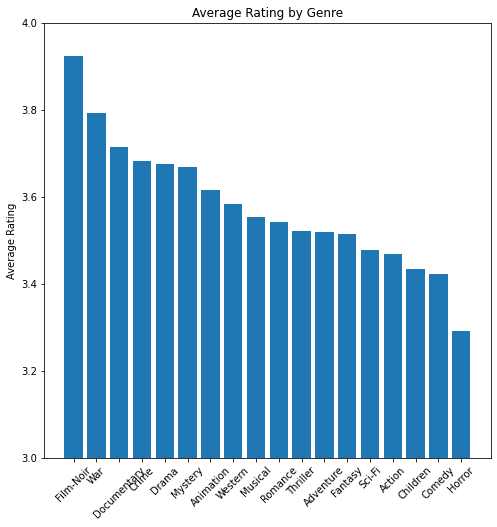

In [67]:
plt.figure(figsize=(8, 8))
plt.bar(genre_avg_df['Genre'],genre_avg_df['Average Rating'])
plt.ylim(3, 4)
plt.title('Average Rating by Genre')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.savefig('images/avg_rating_by_genre.png')

In [68]:
def ratings_by_year(genre, year):
    df = reduced[reduced['genres'].str.contains(genre, regex=False)]
    year_df = df.loc[df['release_year'] == year]
    avg_rating = year_df.groupby('release_year')['rating'].mean()
    return avg_rating[0]

In [69]:
ratings_by_year('Action','1995')

3.2676017449886796

In [70]:
ratings_dict = {
    'Year': [],
    'Average Rating': []
}

years = ['1993','1994','1995','1996','1997','1998','1999','2000','2001','2002','2003','2004','2005','2006',
         '2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018']

for year in years:
    avg = ratings_by_year('Action',year)
    ratings_dict['Average Rating'].append(avg)
    ratings_dict['Year'].append(year)
    
ratings_dict_df = pd.DataFrame(ratings_dict)

In [71]:
ratings_dict_df.head()

,Year,Average Rating
0,1993,3.326545
1,1994,3.332999
2,1995,3.267602
3,1996,3.258325
4,1997,3.245841


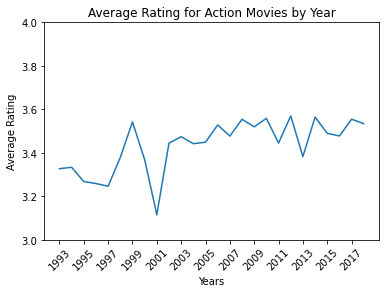

In [72]:
plt.plot(ratings_dict_df['Year'],ratings_dict_df['Average Rating'])
plt.ylim(3, 4)
plt.title('Average Rating for Action Movies by Year')
plt.ylabel('Average Rating')
plt.xlabel('Years')

#every other year for xticks
labels = [n for n in ratings_dict_df['Year']][::2]
plt.xticks(labels,labels=labels,rotation=45)
plt.savefig('images/average_rating_action.png')

In [73]:
# years = ['19'+str(i) for i in range(60, 100)] + ['200'+str(i) for i in range(0,10)] + ['20'+str(i) for i in range(10,19)]
# print(years)

In [81]:
def plot_genre_by_year(genre):
    lower_genre = genre.lower()
    ratings_dict = {
        'Year': [],
        'Average Rating': []
    }

    years = ['19'+str(i) for i in range(60, 100)]+['200'+str(i) for i in range(0,10)]+['20'+str(i) for i in range(10,19)]

    year_labels = years[::4]

    for year in years:
        try:
            avg = ratings_by_year(genre,year)
            ratings_dict['Average Rating'].append(avg)
            ratings_dict['Year'].append(year)
        except:
            pass

    ratings_dict_df = pd.DataFrame(ratings_dict)

    ## Plot
    plt.plot(ratings_dict_df['Year'],ratings_dict_df['Average Rating'], label=genre)
    plt.ylim(3, 5)
    plt.title(f'Average Rating for {genre} Movies by Year')
    plt.ylabel('Average Rating')
    plt.xlabel('Years')
    plt.xticks(year_labels,labels=year_labels,rotation=45)
#     plt.legend(loc="lower left")
    plt.savefig(f'images/avg_rating_by_year_{lower_genre}.png')
    plt.show()

In [88]:
top_genres = ['War','Documentary','Crime','Drama','Mystery','Animation','Action']
# top_genres = ['War']

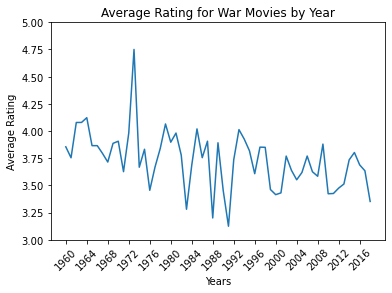

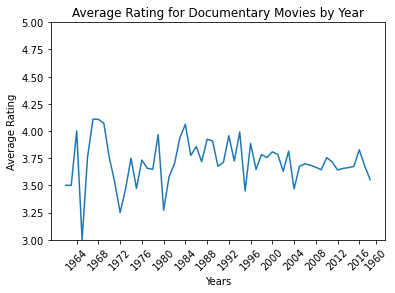

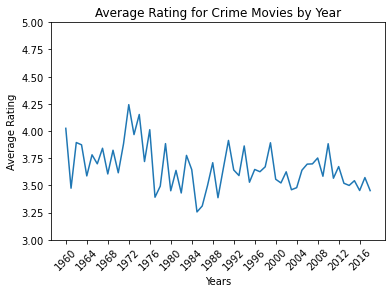

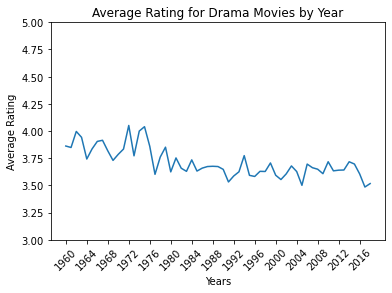

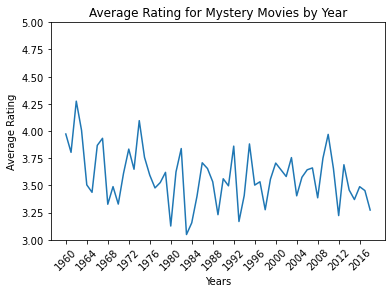

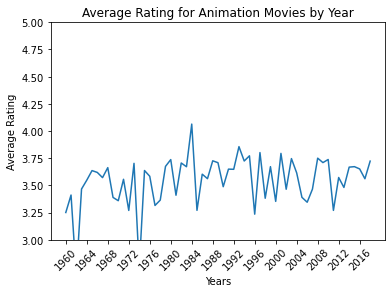

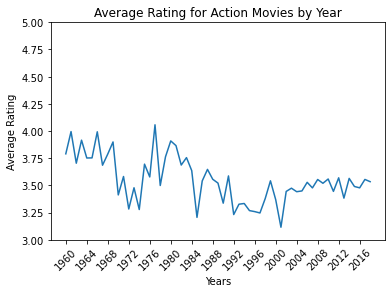

In [87]:
for genre in top_genres:
    plot_genre_by_year(genre)

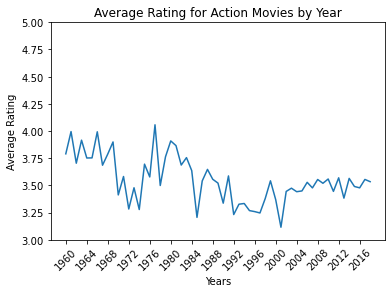

In [89]:
plot_genre_by_year('Action')